<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [ ]:
%%bash
pip install --no-cache-dir -qU \
  tensorflow tensorflow-probability[tf]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


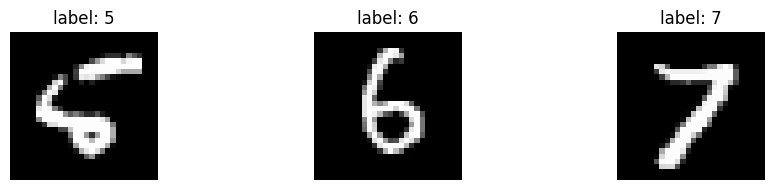

(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 52s


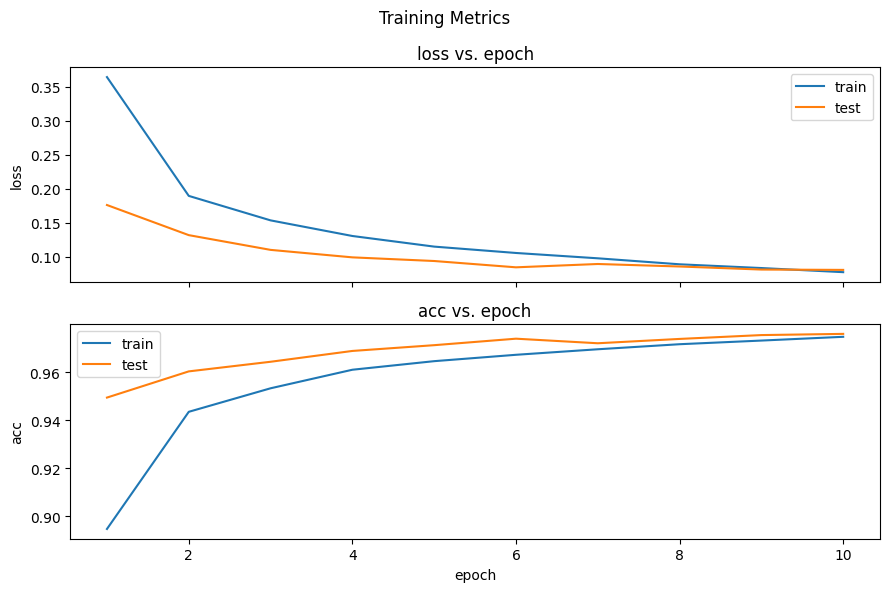

In [ ]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@keras.saving.register_keras_serializable()
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def call(self, inputs):
        return self.preprocess(inputs=inputs)

x = tf.keras.Input(name="Images", shape=(28, 28), dtype=tf.float32)
h = PreprocessingLayer(name="preprocessing")(inputs=x)
h = tf.keras.layers.Dense(units=64,
    activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=h)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
model = tf.keras.Model(inputs=x, outputs=y)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
]

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model, add_history=True,
    callbacks=[ckptModel, reduceLR])

@tf.function(reduce_retracing=True)
def train_step(data):
    x, y = data
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function(reduce_retracing=True)
def test_step(data):
    x, y = data
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"test_{m.name}": m.result() for m in metrics}

start_time = time.time()
history, logs = [], {}
callbacks.on_train_begin(logs=logs)
for epoch in range(10):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for data in ds_train:
        logs = train_step(data=data)
    for m in metrics:
        m.reset_state()

    for data in ds_test:
        logs_test = test_step(data=data)
    logs.update(logs_test)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append({k: v.numpy() for k, v in logs.items()})
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 6))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    ax.set_title(label=f"{m.name} vs. epoch")
    ax.set_ylabel(ylabel=m.name)
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

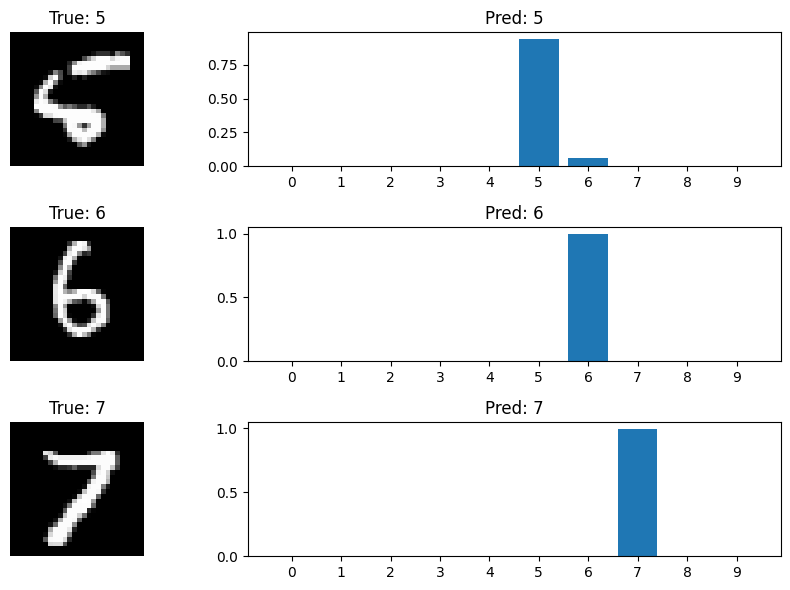

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
model.load_weights(ckptPath)
probs = model(inputs=x_plt)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()

## Models with multiple inputs and outputs

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import model_selection

csv_file = tf.keras.utils.get_file(fname='heart.csv',
    origin='https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

df_data = pd.read_csv(csv_file)
df_train, df_test = model_selection.train_test_split(df_data,
    test_size=0.1, random_state=42)

def get_ds(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df)).cache()
    ds = ds.map(map_func=lambda x: (x, {"target": x.pop("target")}))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(df=df_train, shuffle=True)
ds_test = get_ds(df=df_test, shuffle=False)
ds_train.element_spec

({'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'sex': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'cp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'fbs': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'restecg': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'exang': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'slope': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'thal': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 {'target': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})

In [2]:
import tensorflow as tf

inputs, preprocessed = {}, []

# Binary columns
binary_cols = ["sex", "fbs", "exang"]
for name in binary_cols:
    dtype = ds_train.element_spec[0][name].dtype
    inputs[name] = tf.keras.Input(name=name, shape=(1,), dtype=dtype)
    preprocessed.append(inputs[name])

# Categorical columns
categoric_cols = ["cp", "restecg", "slope", "ca", "thal"]
for name in categoric_cols:
    dtype = ds_train.element_spec[0][name].dtype
    inputs[name] = tf.keras.Input(name=name, shape=(1,), dtype=dtype)
    if dtype=="string":
        lookup = tf.keras.layers.StringLookup(output_mode="one_hot")
    else:
        lookup = tf.keras.layers.IntegerLookup(output_mode="one_hot")
    feature_ds = ds_train.map(lambda x, _: x[name])
    lookup.adapt(data=feature_ds)
    preprocessed.append(lookup(inputs[name]))

# Numerical columns
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
for name in numeric_cols:
    dtype = ds_train.element_spec[0][name].dtype
    inputs[name] = tf.keras.Input(name=name, shape=(1,), dtype=dtype)
    normalizer = tf.keras.layers.Normalization(axis=None)
    feature_ds = ds_train.map(lambda x, _: x[name][:, tf.newaxis])
    normalizer.adapt(data=feature_ds)
    preprocessed.append(normalizer(inputs[name]))

preprocessed_result = tf.keras.layers.Concatenate(axis=-1)(preprocessed)
preprocessor = tf.keras.Model(inputs=inputs, outputs=preprocessed_result)

for x, y in ds_train.take(1):
    print(preprocessor(inputs=x))

tf.Tensor(
[[ 1.          0.          1.         ...  1.0886693  -1.074424
  -0.12764841]
 [ 1.          0.          0.         ... -0.71019876  0.50266546
  -0.90690845]
 [ 1.          0.          1.         ...  0.2914437  -0.41730338
   2.2101316 ]
 ...
 [ 1.          0.          1.         ...  1.2930862  -0.8115758
   0.6516116 ]
 [ 1.          0.          1.         ... -0.11738995  0.19600916
  -0.38740173]
 [ 0.          0.          1.         ...  0.47541884 -1.2496562
  -0.73373955]], shape=(32, 33), dtype=float32)


Training duration:  5s


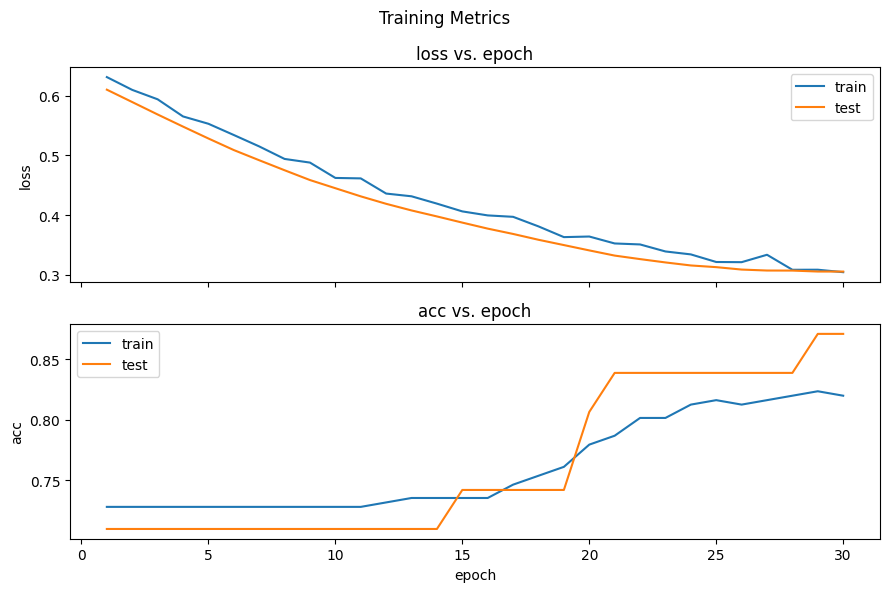

In [6]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

x = preprocessor(inputs)
h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu)(x)
h = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.relu)(h)
predicted_target = tf.keras.layers.Dense(units=1)(h)
model = tf.keras.Model(inputs=inputs, outputs=predicted_target)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.BinaryAccuracy(name="acc")
]

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=10, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model, add_history=True,
    callbacks=[ckptModel, reduceLR])

@tf.function(reduce_retracing=True)
def train_step(data):
    x, y = data
    y = y["target"]
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function(reduce_retracing=True)
def test_step(data):
    x, y = data
    y = y["target"]
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"test_{m.name}": m.result() for m in metrics}

start_time = time.time()
history, logs = [], {}
callbacks.on_train_begin(logs=logs)
for epoch in range(30):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for data in ds_train:
        logs = train_step(data=data)
    for m in metrics:
        m.reset_state()

    for data in ds_test:
        logs_test = test_step(data=data)
    logs.update(logs_test)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append({k: v.numpy() for k, v in logs.items()})
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 6))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    ax.set_title(label=f"{m.name} vs. epoch")
    ax.set_ylabel(ylabel=m.name)
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

In [7]:
model.load_weights(ckptPath)
X_test = df_test.drop(columns=["target"])
model(inputs=dict(X_test))

<tf.Tensor: shape=(31, 1), dtype=float32, numpy=
array([[-0.42865735],
       [ 0.04943346],
       [-3.1467247 ],
       [-4.345779  ],
       [-2.2726936 ],
       [ 0.20919098],
       [ 0.1515538 ],
       [-4.5981684 ],
       [-2.8146276 ],
       [-2.4283788 ],
       [-6.214481  ],
       [ 0.4154752 ],
       [-2.7375362 ],
       [-0.510296  ],
       [ 0.9868223 ],
       [-2.671166  ],
       [ 0.26769647],
       [-0.22060744],
       [-4.2622714 ],
       [-2.0703864 ],
       [ 0.55525017],
       [-1.3218544 ],
       [-0.09901558],
       [-3.3102973 ],
       [-2.858821  ],
       [ 1.1341153 ],
       [-4.0787187 ],
       [-2.3448894 ],
       [ 1.3560628 ],
       [-3.0799835 ],
       [ 2.2218654 ]], dtype=float32)>